In [1]:
from BinaryNet.utils.ClassificationTrainer import ClassificationTrainer
from BinaryNet.utils.Dataset import SCWithFeatures, FilteredSubsetSC, TARGET_WORDS
from BinaryNet.utils.SoundUtils import prepareMelSpectrogram

import os

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


In [2]:
DATA_DIR = os.path.abspath('../data')
SPEECHCOMMANDS_DATASET_PATH = os.path.join(DATA_DIR, "SPEECHCOMMANDS")

class_counts = len(TARGET_WORDS)
train = SCWithFeatures(FilteredSubsetSC(SPEECHCOMMANDS_DATASET_PATH, "training", TARGET_WORDS), prepareMelSpectrogram)
val   = SCWithFeatures(FilteredSubsetSC(SPEECHCOMMANDS_DATASET_PATH, "validation", TARGET_WORDS), prepareMelSpectrogram)

trainer = ClassificationTrainer(train, val)

## Наивная реализация XNOR Net из статьи

https://arxiv.org/pdf/1603.05279 XNOR-Net: ImageNet Classification Using Binary Convolutional Neural Networks


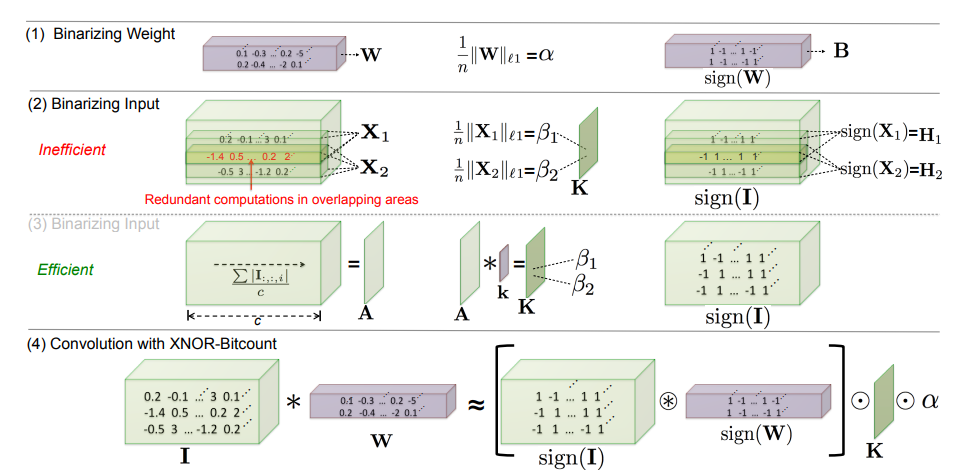

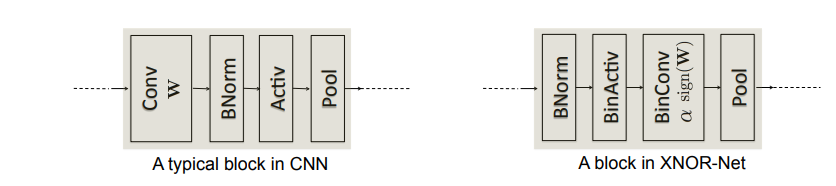

In [14]:
import torch
import torch.nn as nn

class SignSTE(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x.sign()
    @staticmethod
    def backward(ctx, g):
        (x,) = ctx.saved_tensors
        mask = (x.abs() <= 1).to(g.dtype)
        return g * mask

class NaiveXNORLinear(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(NaiveXNORLinear, self).__init__()
        self.fc = nn.Linear(ch_in, ch_out, bias=True)

    def forward(self, input_x):
        quantized_weight = SignSTE.apply(self.fc.weight)
        quintized_input = SignSTE.apply(input_x)
        out = nn.functional.linear(quintized_input, quantized_weight)
        alpha = self.fc.weight.abs().mean()
        betta = input_x.abs().mean()
        return out*alpha*betta + self.fc.bias
    
class NaiveXNORConv2d(nn.Module):
    def __init__(self, ch_in,ch_out, kernel=3, padding=0, stride=1):
        super(NaiveXNORConv2d, self).__init__()
        self.padding = padding
        self.stride = stride
        self.conv = nn.Conv2d(ch_in, ch_out, kernel, stride, padding, bias=False)
        k = torch.ones((1, 1, kernel, kernel))/(kernel**2) #< Now consider only constants
        self.k = nn.parameter.Buffer(k, persistent=False)

    def forward(self, input_x):
        # A, k - BinActiv
        A = input_x.abs().mean(axis=1, keepdim=True)
        K = nn.functional.conv2d(A, self.k, None, self.stride, self.padding)
        alpha = self.conv.weight.abs().mean()

        quantized_weight = SignSTE.apply(self.conv.weight)
        quintized_input = SignSTE.apply(input_x)
        out = nn.functional.conv2d(quintized_input, quantized_weight, None, self.stride, self.padding)
        return out*K*alpha
    
class NaiveXNORSimpleCNN(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, (5,5), padding=2),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2), stride=2),
            torch.nn.BatchNorm2d(64),
            NaiveXNORConv2d(64, 96, 3, padding=1),
            torch.nn.MaxPool2d((2,2), stride=2),
            torch.nn.BatchNorm2d(96),
            NaiveXNORConv2d(96, 128, 3, padding=1),
            torch.nn.BatchNorm2d(128),
            NaiveXNORConv2d(128, 256, 3, padding=1),
            torch.nn.AdaptiveAvgPool2d((1,1)),
            torch.nn.Flatten()
        )
        self.fc = torch.nn.Sequential(
            NaiveXNORLinear(256, 64),
            torch.nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        z = self.net(x)
        return self.fc(z)

In [11]:
SIMPLECNN_DIR = os.path.abspath('./models/NaiveXNORSimpleCNN')
SIMPLECNN_CHECKPOINTS_DIR = os.path.join(SIMPLECNN_DIR, 'checkpoints')
os.makedirs(SIMPLECNN_CHECKPOINTS_DIR, exist_ok=True)

model = trainer.fit(20, NaiveXNORSimpleCNN(class_counts), bs_test=512, save_path=SIMPLECNN_CHECKPOINTS_DIR)

100%|██████████| 241/241 [01:10<00:00,  3.42it/s]


epoch - 0: loss = 1.3163374662399292, f1 = 0.5209910633335028


100%|██████████| 241/241 [00:48<00:00,  4.93it/s]


epoch - 1: loss = 1.1806118488311768, f1 = 0.5845775777545856


100%|██████████| 241/241 [00:48<00:00,  4.92it/s]


epoch - 2: loss = 0.8124085664749146, f1 = 0.7534382799225122


100%|██████████| 241/241 [00:48<00:00,  4.95it/s]


epoch - 3: loss = 1.4537081718444824, f1 = 0.4860874362872864


100%|██████████| 241/241 [00:48<00:00,  4.98it/s]


epoch - 4: loss = 1.237527847290039, f1 = 0.6216049654810091


100%|██████████| 241/241 [00:48<00:00,  4.95it/s]


epoch - 5: loss = 1.064855694770813, f1 = 0.6583108520989684


100%|██████████| 241/241 [00:48<00:00,  4.93it/s]


epoch - 6: loss = 0.9602698683738708, f1 = 0.711939709168288


100%|██████████| 241/241 [00:48<00:00,  4.95it/s]


epoch - 7: loss = 0.741888701915741, f1 = 0.7450594149445914


100%|██████████| 241/241 [00:48<00:00,  4.96it/s]


epoch - 8: loss = 0.6299472451210022, f1 = 0.8057431646777216


100%|██████████| 241/241 [00:49<00:00,  4.91it/s]


epoch - 9: loss = 0.5398514270782471, f1 = 0.8335899584559145


100%|██████████| 241/241 [00:49<00:00,  4.91it/s]


epoch - 10: loss = 0.8706571459770203, f1 = 0.7106877599925044


100%|██████████| 241/241 [00:49<00:00,  4.91it/s]


epoch - 11: loss = 0.6206880807876587, f1 = 0.8140235729042444


100%|██████████| 241/241 [00:48<00:00,  4.94it/s]


epoch - 12: loss = 0.6109007596969604, f1 = 0.8137797175025385


100%|██████████| 241/241 [00:48<00:00,  5.00it/s]


epoch - 13: loss = 0.8868172764778137, f1 = 0.7114451866838226


100%|██████████| 241/241 [00:48<00:00,  4.96it/s]


epoch - 14: loss = 0.4813333749771118, f1 = 0.8572262871757461


100%|██████████| 241/241 [00:49<00:00,  4.92it/s]


epoch - 15: loss = 0.48294976353645325, f1 = 0.8378516920969232


100%|██████████| 241/241 [00:48<00:00,  4.92it/s]


epoch - 16: loss = 0.5751422047615051, f1 = 0.8242090659646125


100%|██████████| 241/241 [00:48<00:00,  4.92it/s]


epoch - 17: loss = 0.5885447859764099, f1 = 0.8116040627987186


100%|██████████| 241/241 [00:48<00:00,  4.97it/s]


epoch - 18: loss = 0.645226240158081, f1 = 0.7872983309782076


100%|██████████| 241/241 [00:48<00:00,  4.98it/s]


epoch - 19: loss = 0.9086512327194214, f1 = 0.7082071252915052


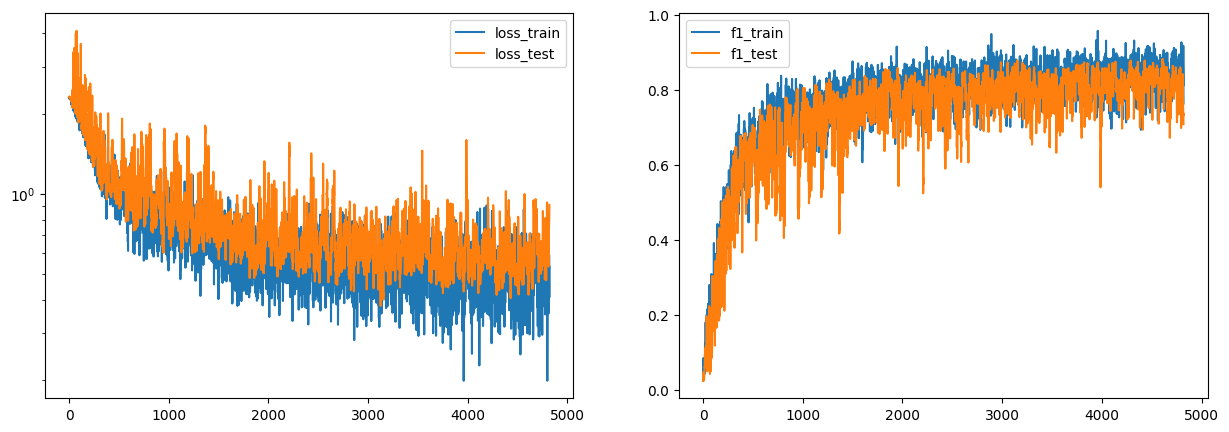

In [12]:
trainer.visualize(filename=os.path.join(SIMPLECNN_DIR, "learning.jpg"))

In [17]:
class NaiveXNORLinearImproved(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.fc = nn.Linear(ch_in, ch_out, bias=True)

    def forward(self, x):
        w_bin = SignSTE.apply(self.fc.weight)
        x_bin = SignSTE.apply(x)
        y = nn.functional.linear(x_bin, w_bin, bias=None)
        alpha = self.fc.weight.abs().mean(dim=1, keepdim=True).t()
        beta  = x.abs().mean(dim=1, keepdim=True)
        y = y * alpha.view(1, -1) * beta
        return y + self.fc.bias
    
class NaiveXNORConv2dImproved(nn.Module):
    def __init__(self, ch_in,ch_out, kernel=3, padding=0, stride=1):
        super().__init__()
        self.padding = padding
        self.stride = stride
        self.conv = nn.Conv2d(ch_in, ch_out, kernel, stride, padding, bias=False)
        k = torch.ones((1, 1, kernel, kernel))/(kernel**2) #< Now consider only constants
        self.k = nn.parameter.Buffer(k, persistent=False)

    def forward(self, input_x):
        # A, k - BinActiv
        A = input_x.abs().mean(axis=1, keepdim=True)
        K = nn.functional.conv2d(A, self.k, None, self.stride, self.padding)

        w_bin = SignSTE.apply(self.conv.weight)
        x_bin = SignSTE.apply(input_x)
        out = nn.functional.conv2d(x_bin, w_bin, None, self.stride, self.padding)

        alpha = self.conv.weight.abs().mean(dim=(1,2,3), keepdim=True) # [out,1,1,1]
        return out * alpha.view(1, -1, 1, 1) * K 
    
class NaiveXNORSimpleCNNImproved(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, (5,5), padding=2),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2), stride=2),
            torch.nn.BatchNorm2d(64),
            NaiveXNORConv2dImproved(64, 96, 3, padding=1),
            torch.nn.MaxPool2d((2,2), stride=2),
            torch.nn.BatchNorm2d(96),
            NaiveXNORConv2dImproved(96, 128, 3, padding=1),
            torch.nn.BatchNorm2d(128),
            NaiveXNORConv2dImproved(128, 256, 3, padding=1),
            torch.nn.AdaptiveAvgPool2d((1,1)),
            torch.nn.Flatten()
        )
        self.fc = torch.nn.Sequential(
            NaiveXNORLinearImproved(256, 64),
            torch.nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        z = self.net(x)
        return self.fc(z)

In [18]:
SIMPLECNN_DIR = os.path.abspath('./models/NaiveXNORSimpleCNNImproved')
SIMPLECNN_CHECKPOINTS_DIR = os.path.join(SIMPLECNN_DIR, 'checkpoints')
os.makedirs(SIMPLECNN_CHECKPOINTS_DIR, exist_ok=True)

model = trainer.fit(20, NaiveXNORSimpleCNNImproved(class_counts), bs_test=512, save_path=SIMPLECNN_CHECKPOINTS_DIR)

100%|██████████| 241/241 [00:48<00:00,  4.99it/s]


epoch - 0: loss = 2.0955193042755127, f1 = 0.3022379899569009


100%|██████████| 241/241 [00:47<00:00,  5.02it/s]


epoch - 1: loss = 1.1755409240722656, f1 = 0.6108764117514273


100%|██████████| 241/241 [00:48<00:00,  5.01it/s]


epoch - 2: loss = 1.0557780265808105, f1 = 0.6161437891744264


100%|██████████| 241/241 [00:48<00:00,  5.01it/s]


epoch - 3: loss = 0.8052912354469299, f1 = 0.7047391975248003


100%|██████████| 241/241 [00:48<00:00,  5.01it/s]


epoch - 4: loss = 0.772912323474884, f1 = 0.727832627598354


100%|██████████| 241/241 [00:48<00:00,  4.94it/s]


epoch - 5: loss = 0.8555909395217896, f1 = 0.7043837676656118


100%|██████████| 241/241 [00:48<00:00,  4.94it/s]


epoch - 6: loss = 0.7930165529251099, f1 = 0.7331455112355965


100%|██████████| 241/241 [00:48<00:00,  5.00it/s]


epoch - 7: loss = 0.7441438436508179, f1 = 0.7451677114738373


100%|██████████| 241/241 [00:48<00:00,  5.00it/s]


epoch - 8: loss = 0.7652862071990967, f1 = 0.7465799681972621


100%|██████████| 241/241 [00:48<00:00,  5.00it/s]


epoch - 9: loss = 0.5787348747253418, f1 = 0.8180347451409364


100%|██████████| 241/241 [00:48<00:00,  5.00it/s]


epoch - 10: loss = 0.6773608326911926, f1 = 0.7652531984895804


100%|██████████| 241/241 [00:48<00:00,  4.99it/s]


epoch - 11: loss = 0.47184887528419495, f1 = 0.8392056846741754


100%|██████████| 241/241 [00:48<00:00,  5.00it/s]


epoch - 12: loss = 0.5127061009407043, f1 = 0.8189658929240788


100%|██████████| 241/241 [00:48<00:00,  5.00it/s]


epoch - 13: loss = 0.6901041865348816, f1 = 0.7886194117746114


100%|██████████| 241/241 [00:48<00:00,  4.93it/s]


epoch - 14: loss = 0.9126861095428467, f1 = 0.7090443680035086


100%|██████████| 241/241 [00:48<00:00,  4.92it/s]


epoch - 15: loss = 0.49510592222213745, f1 = 0.8280403183955594


100%|██████████| 241/241 [00:48<00:00,  5.00it/s]


epoch - 16: loss = 0.6451073884963989, f1 = 0.7825443436029411


100%|██████████| 241/241 [00:48<00:00,  5.00it/s]


epoch - 17: loss = 0.6156284213066101, f1 = 0.7832242762866517


100%|██████████| 241/241 [00:48<00:00,  4.99it/s]


epoch - 18: loss = 0.564818263053894, f1 = 0.8153527648400912


100%|██████████| 241/241 [00:48<00:00,  4.97it/s]


epoch - 19: loss = 0.4671001136302948, f1 = 0.8396449844457342


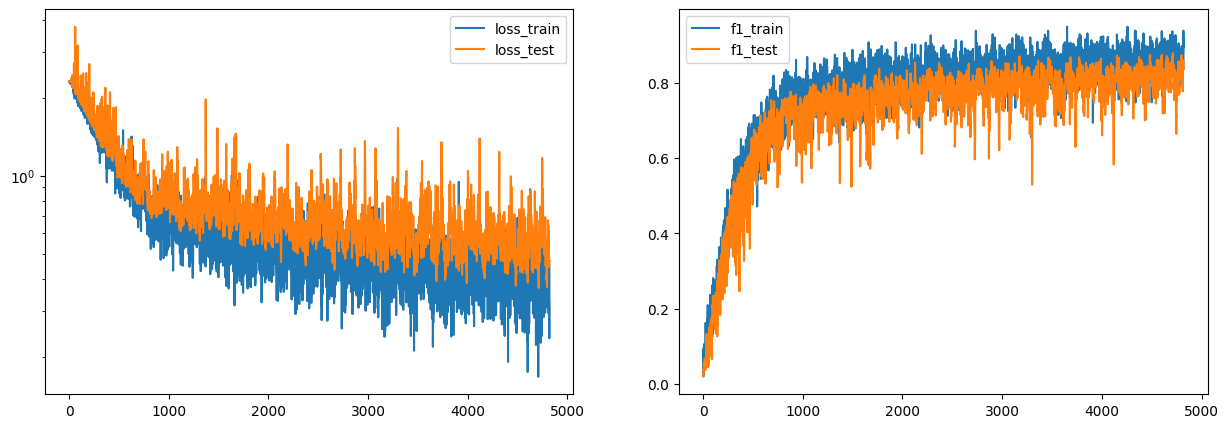

In [19]:
trainer.visualize(filename=os.path.join(SIMPLECNN_DIR, "learning.jpg"))

## Используем готовую реализацию из репозиториев

* https://github.com/allenai/XNOR-Net - оригинальный репозиторий на lua
* https://github.com/cooooorn/Pytorch-XNOR-Net
* https://github.com/jiecaoyu/XNOR-Net-PyTorch

In [3]:
from BinaryNet.binary_layers.XNORFromRepository import BinConv2d
import torch

class XNORFromRepositorySimpleCNN(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, (5,5), padding=2),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2), stride=2),
            BinConv2d(64, 96, (3,3), padding=1),
            torch.nn.MaxPool2d((2,2), stride=2),
            BinConv2d(96, 128, (3,3), padding=1),
            BinConv2d(128, 256, (3,3), padding=1),
            torch.nn.AdaptiveAvgPool2d((1,1)),
            torch.nn.Flatten()
        )
        self.fc = torch.nn.Sequential(
            BinConv2d(256, 64, Linear=True),
            torch.nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        z = self.net(x)
        return self.fc(z)

In [4]:
# Используем отдельный trainer, т.к. градиент и бинаризация весов реализованы отдельно от BinConv2d
from BinaryNet.utils.BinOpClassificationTrainer import BinOpClassificationTrainer
trainer_bin_op = BinOpClassificationTrainer(train, val)

In [5]:
SIMPLECNN_DIR = os.path.abspath('./models/XNORFromRepositorySimpleCNN')
SIMPLECNN_CHECKPOINTS_DIR = os.path.join(SIMPLECNN_DIR, 'checkpoints')
os.makedirs(SIMPLECNN_CHECKPOINTS_DIR, exist_ok=True)

import warnings
warnings.filterwarnings('ignore')

model = trainer_bin_op.fit(20, XNORFromRepositorySimpleCNN(class_counts), bs_test=512, save_path=SIMPLECNN_CHECKPOINTS_DIR)

100%|██████████| 241/241 [00:46<00:00,  5.19it/s]


epoch - 0: loss = 1.1530600786209106, f1 = 0.5985802104214889


100%|██████████| 241/241 [00:45<00:00,  5.26it/s]


epoch - 1: loss = 0.7137041687965393, f1 = 0.7538746226401225


100%|██████████| 241/241 [00:45<00:00,  5.32it/s]


epoch - 2: loss = 0.6204883456230164, f1 = 0.779052887709102


100%|██████████| 241/241 [00:44<00:00,  5.39it/s]


epoch - 3: loss = 0.6886969208717346, f1 = 0.7578493543559153


100%|██████████| 241/241 [00:44<00:00,  5.38it/s]


epoch - 4: loss = 0.378314733505249, f1 = 0.8596139891291188


100%|██████████| 241/241 [00:44<00:00,  5.39it/s]


epoch - 5: loss = 0.5069817900657654, f1 = 0.8238573236921889


100%|██████████| 241/241 [00:44<00:00,  5.38it/s]


epoch - 6: loss = 0.3317480683326721, f1 = 0.9036276108851865


100%|██████████| 241/241 [01:12<00:00,  3.31it/s]


epoch - 7: loss = 0.2408064901828766, f1 = 0.9291436082758509


100%|██████████| 241/241 [00:44<00:00,  5.39it/s]


epoch - 8: loss = 0.2373865842819214, f1 = 0.9113685290584866


100%|██████████| 241/241 [00:45<00:00,  5.34it/s]


epoch - 9: loss = 0.22047492861747742, f1 = 0.9251486177789486


100%|██████████| 241/241 [00:45<00:00,  5.31it/s]


epoch - 10: loss = 0.21615900099277496, f1 = 0.9285332233148968


100%|██████████| 241/241 [00:45<00:00,  5.32it/s]


epoch - 11: loss = 0.2921498715877533, f1 = 0.9037502803675499


100%|██████████| 241/241 [00:45<00:00,  5.31it/s]


epoch - 12: loss = 0.24737954139709473, f1 = 0.9180464671358189


100%|██████████| 241/241 [00:46<00:00,  5.21it/s]


epoch - 13: loss = 0.27275359630584717, f1 = 0.9144413104956683


100%|██████████| 241/241 [00:46<00:00,  5.24it/s]


epoch - 14: loss = 0.2808551788330078, f1 = 0.9070742661762345


100%|██████████| 241/241 [00:46<00:00,  5.17it/s]


epoch - 15: loss = 0.2866103947162628, f1 = 0.9004557612488734


100%|██████████| 241/241 [00:46<00:00,  5.23it/s]


epoch - 16: loss = 0.35229742527008057, f1 = 0.8878468098902111


100%|██████████| 241/241 [00:46<00:00,  5.24it/s]


epoch - 17: loss = 0.2564828097820282, f1 = 0.9073888727665743


100%|██████████| 241/241 [00:46<00:00,  5.23it/s]


epoch - 18: loss = 0.2758603096008301, f1 = 0.9114225085625967


100%|██████████| 241/241 [00:46<00:00,  5.22it/s]


epoch - 19: loss = 0.23253196477890015, f1 = 0.9238609022886053


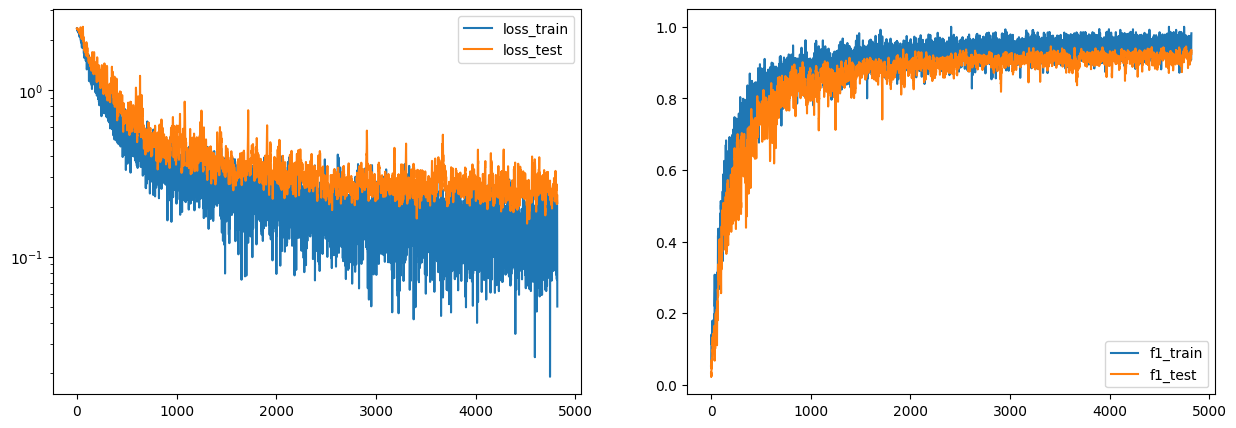

In [6]:
trainer_bin_op.visualize(filename=os.path.join(SIMPLECNN_DIR, "learning.jpg"))

## Рефакторинг готовой реализации

In [3]:
import torch
import torch.nn as nn

class BinWeightFn(torch.autograd.Function):
    @staticmethod
    def forward(ctx, weight: torch.Tensor):
        if weight.dim() == 4:
            # [out, in, kh, kw]
            negMean = weight.mean(dim=1, keepdim=True).mul(-1).expand_as(weight)
        elif weight.dim() == 2:
            # [out, in]
            negMean = weight.mean(dim=1, keepdim=True).mul(-1).expand_as(weight)

        w_centered = weight + negMean
        w_clamped  = w_centered.clamp_(-1.0, 1.0)

        if weight.dim() == 4:
            n = weight[0].numel()
            m = (w_clamped.norm(p=1, dim=3, keepdim=True)
                           .sum(2, keepdim=True)
                           .sum(1, keepdim=True)
                           .div(n))
        else:
            n = weight.size(1)
            m = w_clamped.norm(p=1, dim=1, keepdim=True).div(n)

        w_bin = w_clamped.sign()

        ctx.save_for_backward(w_clamped)
        ctx.n = n
        return w_bin, m

    @staticmethod
    def backward(ctx, grad_out: torch.Tensor, scale_grad:torch.Tensor):
        (w_clamped,) = ctx.saved_tensors
        n = ctx.n
        s = w_clamped.size()

        g = grad_out
        if w_clamped.dim() == 4:
            m = (w_clamped.norm(p=1, dim=3, keepdim=True)
                              .sum(2, keepdim=True)
                              .sum(1, keepdim=True)
                              .div(n)).expand(s)
        else:
            m = w_clamped.norm(p=1, dim=1, keepdim=True).div(n).expand(s)

        m = m.clone()
        m[w_clamped.lt(-1.0)] = 0
        m[w_clamped.gt( 1.0)] = 0

        grad = m * g

        m_add = w_clamped.sign() * g
        if w_clamped.dim() == 4:
            m_add = (m_add.sum(3, keepdim=True)
                           .sum(2, keepdim=True)
                           .sum(1, keepdim=True)
                           .div(n)
                           .expand(s))
        else:
            m_add = m_add.sum(1, keepdim=True).div(n).expand(s)

        m_add = m_add * w_clamped.sign()
        grad = (grad + m_add) * (1.0 - 1.0 / s[1]) * n
        #grad = grad * 1e9
        return grad
    
class BinActive(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        input = input.sign()
        return input
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input.ge(1)] = 0
        grad_input[input.le(-1)] = 0
        return grad_input

class BinConv2d_Impl(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        x_bin = BinActive.apply(x)
        w_bin, scale = BinWeightFn.apply(self.weight)
        y = nn.functional.conv2d(x_bin, w_bin, self.bias,
                                 self.stride, self.padding,
                                 self.dilation, self.groups)
        return y * scale.view(1, -1, 1, 1)
    
class BinLinear_Impl(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias=bias)

    def forward(self, x):
        x_bin = BinActive.apply(x)
        w_bin, scale = BinWeightFn.apply(self.weight)
        y = nn.functional.linear(x_bin, w_bin, self.bias)
        return y * scale.view(1, -1)

class BinConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_channels, eps=1e-4, momentum=0.1, affine=True)
        self.conv = BinConv2d_Impl(in_channels, out_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, groups=groups)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.bn(x)
        x = self.conv(x)
        x = self.relu(x)
        return x

class BinLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.bn = nn.BatchNorm1d(in_features, eps=1e-4, momentum=0.1, affine=True)
        self.linear = BinLinear_Impl(in_features, out_features, bias=bias)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.bn(x)
        x = self.linear(x)
        x = self.relu(x)
        return x

class XNORSimpleCNN(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, (5,5), padding=2),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2), stride=2),
            BinConv2d(64, 96, (3,3), padding=1),
            torch.nn.MaxPool2d((2,2), stride=2),
            BinConv2d(96, 128, (3,3), padding=1),
            BinConv2d(128, 256, (3,3), padding=1),
            torch.nn.AdaptiveAvgPool2d((1,1)),
            torch.nn.Flatten()
        )
        self.fc = torch.nn.Sequential(
            BinLinear(256, 64),
            torch.nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        z = self.net(x)
        return self.fc(z)

In [4]:
SIMPLECNN_DIR = os.path.abspath('./models/XNORSimpleCNN')
SIMPLECNN_CHECKPOINTS_DIR = os.path.join(SIMPLECNN_DIR, 'checkpoints')
os.makedirs(SIMPLECNN_CHECKPOINTS_DIR, exist_ok=True)

model = trainer.fit(20, XNORSimpleCNN(class_counts), bs_test=512, save_path=SIMPLECNN_CHECKPOINTS_DIR)

100%|██████████| 241/241 [00:48<00:00,  5.01it/s]


epoch - 0: loss = 1.0755184888839722, f1 = 0.5985957035342132


100%|██████████| 241/241 [00:47<00:00,  5.10it/s]


epoch - 1: loss = 0.5370922088623047, f1 = 0.8279580038933847


100%|██████████| 241/241 [00:47<00:00,  5.09it/s]


epoch - 2: loss = 0.516358494758606, f1 = 0.8250579907843569


100%|██████████| 241/241 [00:47<00:00,  5.09it/s]


epoch - 3: loss = 0.3876439929008484, f1 = 0.8790845196972448


100%|██████████| 241/241 [00:47<00:00,  5.09it/s]


epoch - 4: loss = 0.41206440329551697, f1 = 0.8650586989187641


100%|██████████| 241/241 [00:47<00:00,  5.08it/s]


epoch - 5: loss = 0.30558839440345764, f1 = 0.8961463768170777


100%|██████████| 241/241 [00:47<00:00,  5.05it/s]


epoch - 6: loss = 0.3564170002937317, f1 = 0.8864162249408473


100%|██████████| 241/241 [00:48<00:00,  5.02it/s]


epoch - 7: loss = 0.35597333312034607, f1 = 0.8844121128335157


100%|██████████| 241/241 [00:48<00:00,  5.02it/s]


epoch - 8: loss = 0.40355825424194336, f1 = 0.8775197234985507


100%|██████████| 241/241 [00:47<00:00,  5.03it/s]


epoch - 9: loss = 0.2794829308986664, f1 = 0.900249600893989


100%|██████████| 241/241 [00:47<00:00,  5.03it/s]


epoch - 10: loss = 0.27911993861198425, f1 = 0.9079564006117664


100%|██████████| 241/241 [00:47<00:00,  5.06it/s]


epoch - 11: loss = 0.3735973834991455, f1 = 0.8892990162347539


100%|██████████| 241/241 [00:47<00:00,  5.08it/s]


epoch - 12: loss = 0.2687113583087921, f1 = 0.9138474684028175


100%|██████████| 241/241 [00:47<00:00,  5.07it/s]


epoch - 13: loss = 0.2775493562221527, f1 = 0.9247723850574818


100%|██████████| 241/241 [00:47<00:00,  5.07it/s]


epoch - 14: loss = 0.2526837885379791, f1 = 0.9043890869400266


100%|██████████| 241/241 [00:47<00:00,  5.08it/s]


epoch - 15: loss = 0.2684697210788727, f1 = 0.9106085133712165


100%|██████████| 241/241 [00:47<00:00,  5.05it/s]


epoch - 16: loss = 0.3294318914413452, f1 = 0.9089801084806725


100%|██████████| 241/241 [00:47<00:00,  5.03it/s]


epoch - 17: loss = 0.2865288555622101, f1 = 0.9053973030403737


100%|██████████| 241/241 [00:47<00:00,  5.03it/s]


epoch - 18: loss = 0.2666415870189667, f1 = 0.9256732546332523


100%|██████████| 241/241 [00:47<00:00,  5.03it/s]


epoch - 19: loss = 0.29405277967453003, f1 = 0.8871875445447067


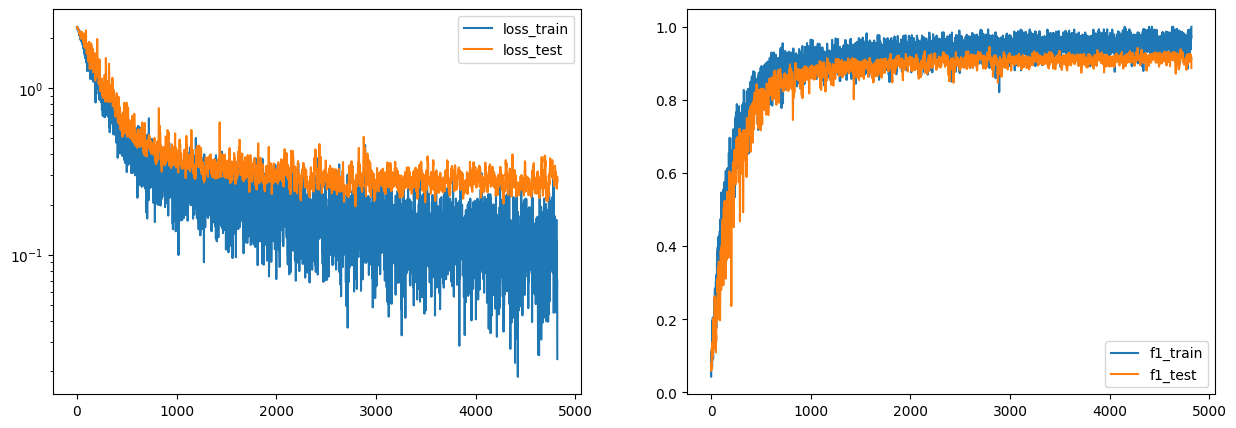

In [5]:
trainer.visualize(filename=os.path.join(SIMPLECNN_DIR, "learning.jpg"))

In [6]:
class BinConv2dWithoutRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_channels, eps=1e-4, momentum=0.1, affine=True)
        self.conv = BinConv2d_Impl(in_channels, out_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, groups=groups)
    def forward(self, x):
        x = self.bn(x)
        x = self.conv(x)
        return x

class BinLinearWithoutRelu(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.bn = nn.BatchNorm1d(in_features, eps=1e-4, momentum=0.1, affine=True)
        self.linear = BinLinear_Impl(in_features, out_features, bias=bias)

    def forward(self, x):
        x = self.bn(x)
        x = self.linear(x)
        return x

class XNORSimpleCNNWithoutRelu(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, (5,5), padding=2),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2), stride=2),
            BinConv2dWithoutRelu(64, 96, (3,3), padding=1),
            torch.nn.MaxPool2d((2,2), stride=2),
            BinConv2dWithoutRelu(96, 128, (3,3), padding=1),
            BinConv2dWithoutRelu(128, 256, (3,3), padding=1),
            torch.nn.AdaptiveAvgPool2d((1,1)),
            torch.nn.Flatten()
        )
        self.fc = torch.nn.Sequential(
            BinLinearWithoutRelu(256, 64),
            torch.nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        z = self.net(x)
        return self.fc(z)

In [7]:
SIMPLECNN_DIR = os.path.abspath('./models/XNORSimpleCNNWithoutRelu')
SIMPLECNN_CHECKPOINTS_DIR = os.path.join(SIMPLECNN_DIR, 'checkpoints')
os.makedirs(SIMPLECNN_CHECKPOINTS_DIR, exist_ok=True)

model = trainer.fit(20, XNORSimpleCNNWithoutRelu(class_counts), bs_test=512, save_path=SIMPLECNN_CHECKPOINTS_DIR)

100%|██████████| 241/241 [00:45<00:00,  5.35it/s]


epoch - 0: loss = 1.6158912181854248, f1 = 0.38707011464322916


100%|██████████| 241/241 [00:44<00:00,  5.40it/s]


epoch - 1: loss = 1.3339073657989502, f1 = 0.507587829859551


100%|██████████| 241/241 [00:44<00:00,  5.39it/s]


epoch - 2: loss = 1.417336106300354, f1 = 0.5081929258524107


100%|██████████| 241/241 [00:44<00:00,  5.39it/s]


epoch - 3: loss = 1.5133492946624756, f1 = 0.5133892094371455


100%|██████████| 241/241 [00:44<00:00,  5.38it/s]


epoch - 4: loss = 1.022863745689392, f1 = 0.6475154849463733


100%|██████████| 241/241 [00:49<00:00,  4.84it/s]


epoch - 5: loss = 1.0810306072235107, f1 = 0.6212952299080378


100%|██████████| 241/241 [01:05<00:00,  3.66it/s]


epoch - 6: loss = 1.352678656578064, f1 = 0.5450022323718862


100%|██████████| 241/241 [00:45<00:00,  5.33it/s]


epoch - 7: loss = 0.902390718460083, f1 = 0.7022660699185354


100%|██████████| 241/241 [00:45<00:00,  5.32it/s]


epoch - 8: loss = 0.9953156113624573, f1 = 0.6678189930208955


100%|██████████| 241/241 [00:45<00:00,  5.32it/s]


epoch - 9: loss = 0.7886719107627869, f1 = 0.7351833314357872


100%|██████████| 241/241 [00:45<00:00,  5.33it/s]


epoch - 10: loss = 0.8865827918052673, f1 = 0.690674055299316


100%|██████████| 241/241 [00:44<00:00,  5.37it/s]


epoch - 11: loss = 0.7208516001701355, f1 = 0.7460067433541121


100%|██████████| 241/241 [00:44<00:00,  5.37it/s]


epoch - 12: loss = 0.6788915991783142, f1 = 0.7613598033750016


100%|██████████| 241/241 [00:44<00:00,  5.37it/s]


epoch - 13: loss = 0.639636754989624, f1 = 0.7940830707801522


100%|██████████| 241/241 [00:44<00:00,  5.37it/s]


epoch - 14: loss = 0.9958031177520752, f1 = 0.6528225420490026


100%|██████████| 241/241 [00:45<00:00,  5.35it/s]


epoch - 15: loss = 1.0035685300827026, f1 = 0.6618469481706192


100%|██████████| 241/241 [00:45<00:00,  5.36it/s]


epoch - 16: loss = 0.7573369145393372, f1 = 0.7319502902148007


100%|██████████| 241/241 [00:45<00:00,  5.35it/s]


epoch - 17: loss = 0.6382632255554199, f1 = 0.791592180198908


100%|██████████| 241/241 [00:44<00:00,  5.36it/s]


epoch - 18: loss = 0.7886394262313843, f1 = 0.754913429583153


100%|██████████| 241/241 [00:45<00:00,  5.35it/s]


epoch - 19: loss = 0.847801685333252, f1 = 0.7316665855867229


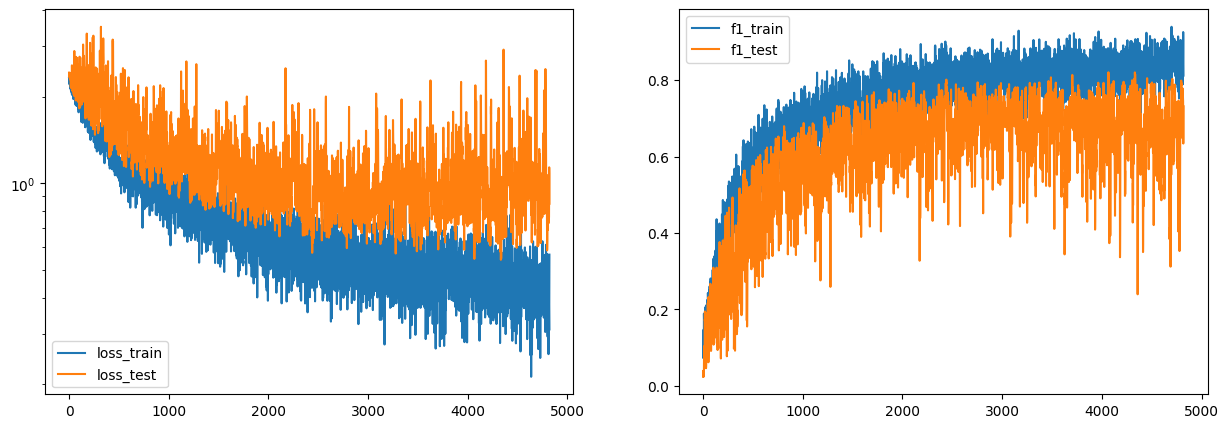

In [8]:
trainer.visualize(filename=os.path.join(SIMPLECNN_DIR, "learning.jpg"))